In [14]:
from copy import deepcopy
from itertools import combinations
import typing as tp

import numpy as np
import pandas as pd
from numpy.linalg import lstsq
from scipy.optimize import linprog
from matplotlib import pyplot as plt
import statsmodels.api as sm

from citk.layer import Dense, FuzzyGMDHLayer, NeoFuzzyLayer
from citk.model import FFN, GMDH
from citk.functions import ReLU, Linear, BellMembership, GaussianMembership, Poly
from citk.losses import MSE, FMSE, RMSE, MAPE
from citk.optimisers import SGDOptimizer

from utils import seed_everything, create_lags

In [15]:
import seaborn as sns
sns.set()

In [55]:
RANDOM_SEED = 42
seed_everything(RANDOM_SEED)

columns_to_keep = ["Open", "Close", "Volume", "Low", "High", "Date"]
data = pd.read_csv("../data/nasdaq_2021.csv", usecols=columns_to_keep)
data.head(5)

,Date,Open,High,Low,Close,Volume
0,2020-12-31,12877.089844,12902.070313,12821.230469,12888.280273,4771390000
1,2021-01-04,12958.519531,12958.719727,12543.240234,12698.450195,6546740000
2,2021-01-05,12665.650391,12828.269531,12665.650391,12818.959961,6904420000
3,2021-01-06,12666.150391,12909.629883,12649.990234,12740.790039,7648340000
4,2021-01-07,12867.339844,13090.910156,12867.339844,13067.480469,6777010000


In [56]:
data_rolling = data.ewm(7).mean()

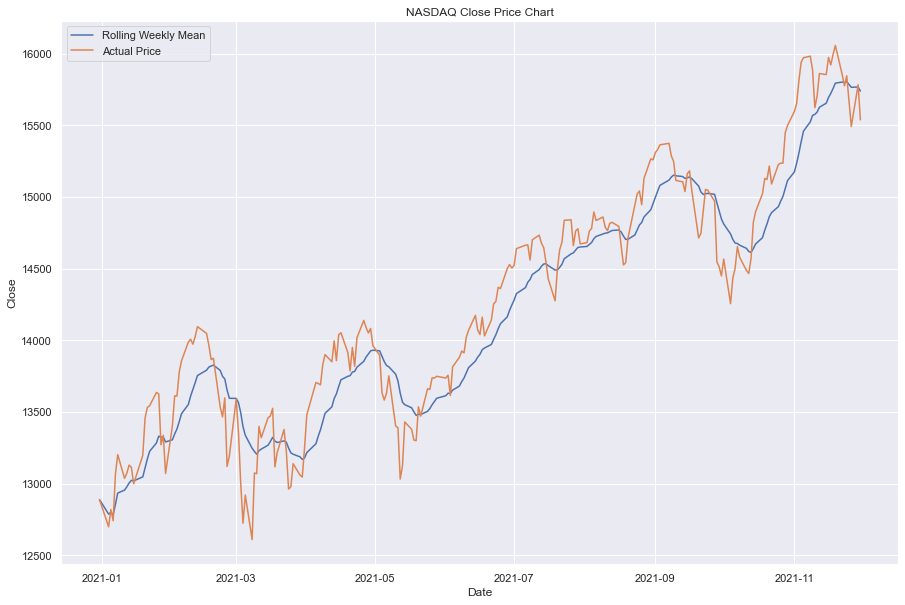

In [57]:
plt.figure(figsize=(15, 10))
plt.title('NASDAQ Close Price Chart')
sns.lineplot(data=data_rolling, x=pd.to_datetime(data.Date), y='Close', label="Rolling Weekly Mean")
sns.lineplot(data=data, x=pd.to_datetime(data.Date), y='Close', label="Actual Price")
plt.legend()
plt.show()

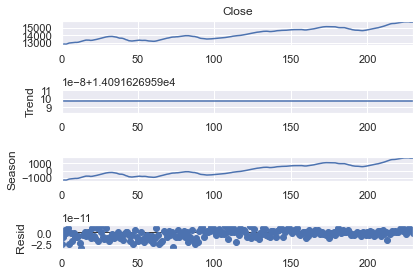

In [58]:
from statsmodels.tsa.seasonal import STL
res = STL(data_rolling.Close, period=365).fit()
res.plot()
plt.show()

In [59]:
data['diff_Close'] = data.Close-data_rolling.Close
data['diff_Open'] = data.Open-data_rolling.Open

<AxesSubplot:ylabel='diff_Close'>

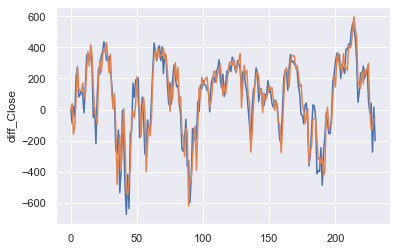

In [60]:
sns.lineplot(data=data, x=data.index, y='diff_Close')
sns.lineplot(data=data, x=data.index, y='diff_Open')

In [61]:
sm.tsa.stattools.adfuller(data.diff_Close, regression='c')

(-4.556706307398623,
 0.00015510333906630975,
 0,
 230,
 {'1%': -3.459105583381277,
  '5%': -2.8741898504150574,
  '10%': -2.5735117958412097},
 2714.866629636089)

/Users/dmytroandrosov/miniforge3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/dmytroandrosov/miniforge3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


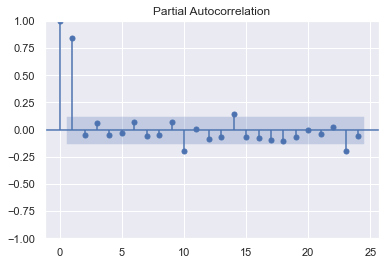

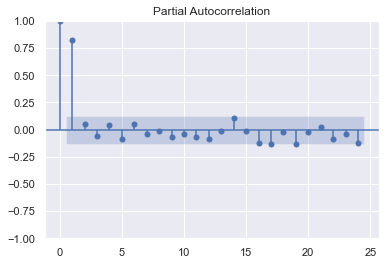

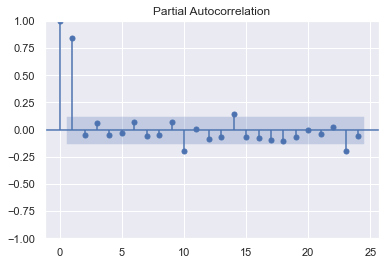

In [62]:
sm.graphics.tsa.plot_pacf(data['diff_Close'].fillna(0))
sm.graphics.tsa.plot_pacf(data['diff_Open'].fillna(0))

In [63]:
def normalize_dataset(train_dataset: pd.DataFrame, test_dataset: pd.DataFrame) -> pd.DataFrame:
    train_dataset_min = train_dataset.min()
    train_dataset_max = train_dataset.max()
    tr_ds = (train_dataset-train_dataset_min)/(train_dataset_max-train_dataset_min)
    test_ds = (test_dataset-train_dataset_min)/(train_dataset_max-train_dataset_min)
    return tr_ds, test_ds

In [64]:
n_lags = 1
test_len = 15
data = data[["Open", "Close", "Volume", "Low", "High"]]
train_df, test_df = data.iloc[-3*test_len:-test_len], data.iloc[-test_len:]

In [65]:
train_df, test_df = normalize_dataset(train_df, test_df)

In [66]:
train_df, test_df = create_lags(
    train_df, test_df, 
    ["Close", "Open", "Low", "High", "Volume"], 
    n_lags
)

In [67]:
train_df = train_df.iloc[n_lags:]

In [68]:
train_df

,Open,Close,Volume,Low,High,Close_1,Open_1,Low_1,High_1,Volume_1
188,0.171021,0.111820,0.679806,0.147523,0.085360,0.148800,0.189854,0.175258,0.113848,0.490698
189,0.119875,0.180221,0.331978,0.079949,0.068922,0.111820,0.171021,0.147523,0.085360,0.679806
190,0.118820,0.000000,0.289596,0.000000,0.000000,0.180221,0.119875,0.079949,0.068922,0.331978
191,0.013657,0.103279,0.176749,0.066338,0.005735,0.000000,0.118820,0.000000,0.000000,0.289596
192,0.000000,0.142702,0.262302,0.043469,0.006314,0.103279,0.013657,0.066338,0.005735,0.176749
193,0.199724,0.230786,0.117834,0.243494,0.164760,0.142702,0.000000,0.043469,0.006314,0.262302
194,0.236432,0.187656,0.010076,0.217957,0.128839,0.230786,0.199724,0.243494,0.164760,0.117834
195,0.146216,0.133605,0.000000,0.169050,0.107006,0.187656,0.236432,0.217957,0.128839,0.010076
196,0.145638,0.121861,0.146531,0.146007,0.034094,0.133605,0.146216,0.169050,0.107006,0.000000
197,0.144518,0.183081,0.145225,0.163017,0.057632,0.121861,0.145638,0.146007,0.034094,0.146531


In [69]:
y_col = "Close"
X_col = train_df.columns.tolist()
X_col.remove(y_col)

X_train = train_df[X_col].values
X_test = test_df[X_col].values
y_train = train_df[y_col].values[..., np.newaxis]
y_test = test_df[y_col].values[..., np.newaxis]

In [70]:
model = GMDH(
            method_type='neo_fuzzy', 
            loss=MSE,
            num_rules=7,
            num_sgd_rounds=2500
        )

In [71]:
model, history  = model.fit(
    (X_train, y_train),
    (X_test, y_test),
    max_gmdh_layers=10,
    n_best_to_take=5,
    verbose=True,
)

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

Layer: 0. Metric: 0.0059909220001569865


One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Layer: 1. Metric: 0.006445300717181719


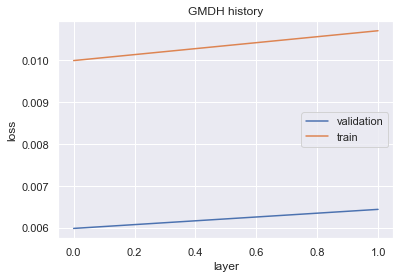

In [62]:
plt.title('GMDH history')
plt.plot(history['validation_loss'], label='validation')
plt.plot(history['train_loss'], label='train')
plt.xlabel('layer')
plt.ylabel('loss')
plt.legend()
plt.show()

In [63]:
prediction = model.predict(X_test)
prediction_train = model.predict(X_train)

In [64]:
print(f"Test RMSE: {RMSE(y_test, prediction)[0]}")
print(f"Train RMSE: {RMSE(y_train, prediction_train)[0]}")

Test RMSE: 0.07740104650556727
Train RMSE: 0.09998047688899539


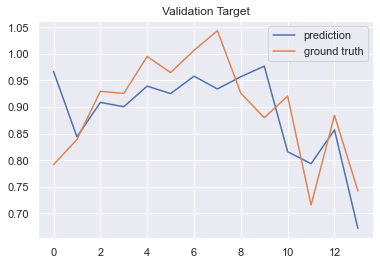

In [65]:
plt.title('Validation Target')
plt.plot(prediction, label='prediction')
plt.plot(y_test, label='ground truth')
plt.legend()
plt.show()

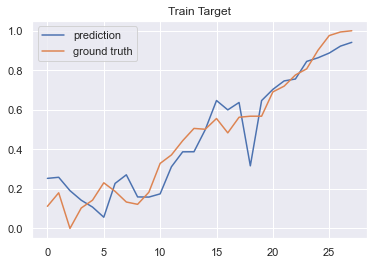

In [66]:
plt.title('Train Target')
plt.plot(prediction_train, label='prediction')
plt.plot(y_train, label='ground truth')
plt.legend()
plt.show()

In [27]:
def brute_force_metrics(dataset: pd.DataFrame, num_rules: tp.List[int], n_best_to_take: tp.List[int], forecast_intervals: tp.List[int]) -> pd.DataFrame:
    res_dict = dict(n_rules=[], n_models=[], forecast_intervals=[], rmse_test=[], mape_test=[])
    for n_rules in num_rules:
        for n_best in n_best_to_take:
            for fint in forecast_intervals:
                res_dict['n_rules'].append(n_rules)
                res_dict['n_models'].append(n_best)
                res_dict['forecast_intervals'].append(fint)
                
                train_df, test_df = data.iloc[-3*fint:-fint], data.iloc[-fint:]
                train_df, test_df = normalize_dataset(train_df, test_df)
                train_df, test_df = create_lags(
                        train_df, test_df, 
                        ["Close", "Open", "Low", "High", "Volume"], 
                        1
                    )
                train_df = train_df.iloc[n_lags:]
                y_col = "Close"
                X_col = train_df.columns.tolist()
                X_col.remove(y_col)

                X_train = train_df[X_col].values
                X_test = test_df[X_col].values
                y_train = train_df[y_col].values[..., np.newaxis]
                y_test = test_df[y_col].values[..., np.newaxis]
                
                model = GMDH(
                        method_type='neo_fuzzy', 
                        loss=MSE,
                        num_rules=n_rules,
                        num_sgd_rounds=2500
                    )
                model, _  = model.fit(
                    (X_train, y_train),
                    (X_test, y_test),
                    max_gmdh_layers=10,
                    n_best_to_take=n_best,
                    verbose=False,
                )
                prediction = model.predict(X_test)
                prediction_train = model.predict(X_train)
                res_dict['rmse_test'].append(RMSE(y_test, prediction)[0])
                res_dict['mape_test'].append(MAPE(y_test, prediction)[0])
    df = pd.DataFrame(res_dict)
    return df                

In [28]:
df = brute_force_metrics(data, num_rules=range(2, 10), n_best_to_take=[5, 10, 15, 20], forecast_intervals=[7, 10, 15])

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/10 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/45 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/105 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/36 [00:00<?, ?it/s]

One fit:   0%|          | 0/190 [00:00<?, ?it/s]

In [29]:
df.to_csv("results.csv", index=False)


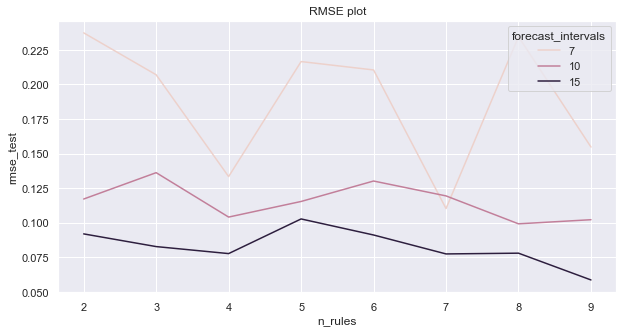

In [54]:
plt.figure(figsize=(10, 5))
plt.title('RMSE plot')
dft = df.groupby(['n_rules','forecast_intervals']).agg({'mape_test':'mean', 'rmse_test': 'mean'}).reset_index()
sns.lineplot(data=dft, x='n_rules', hue='forecast_intervals', y='rmse_test')
plt.show()

In [46]:
dft.reset_index()

,n_rules,forecast_intervals,mape_test,rmse_test
0,2,7,0.000000,0.237354
1,2,10,0.000000,0.117127
2,2,15,0.000000,0.091901
3,3,7,0.000000,0.207020
4,3,10,0.000000,0.136197
5,3,15,0.000000,0.082715
6,4,7,0.000000,0.133368
7,4,10,0.000356,0.104070
8,4,15,0.000409,0.077646
9,5,7,0.000000,0.216582
